In [1]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn import linear_model
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings(action = 'ignore')

/Users/krishnadevabhaktuni/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/krishnadevabhaktuni/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine("postgresql://{}:{}@{}:{}/{}".format(postgres_user, postgres_pw, postgres_host,
                                                           postgres_port, postgres_db))
weatherinszeged_df = pd.read_sql_query('select * from weatherinszeged', con = engine)

engine.dispose()

In [4]:
weatherinszeged_df.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [6]:
X = weatherinszeged_df[['humidity', 'windspeed', 'windbearing', 'pressure']]

In [7]:
X = sm.add_constant(X)

In [8]:
y = weatherinszeged_df['temperature']

In [9]:
results = sm.OLS(y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                 1.750e+04
Date:                Mon, 09 Mar 2020   Prob (F-statistic):               0.00
Time:                        16:24:19   Log-Likelihood:            -3.2821e+05
No. Observations:               96453   AIC:                         6.564e+05
Df Residuals:                   96448   BIC:                         6.565e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          37.9264      0.233    162.709      0.000      37.470      38.383
humidity      -32.4962      0.123   -264.288      0.000     -32.737     -32.255
windspeed      -0.2014      0.003    -57.557      0.000      -0.208      -0.195
windbearing     0.0040      0.000     18.463      0.000       0.004       0.004
pressure       -0.0007      0.000     -3.452      0.001      -0.001      -0.000
==============================================================================
Omnibus:                     3375.432   Durbin-Watson:                   0.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3793.297
Skew:                          -0.455   Prob(JB):                         0.00
Kurtosis:                       3.339   Cond. No.                     1.06e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### we have an R-squared value of 42, which means a random model is better than our model

### Now, check if your model meets the Gauss-Markov Conditions above. If some of the assumptions are not met, discuss the implications of the violations for the correctness of your model.

In [10]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

In [11]:
lrm_example = linear_model.LinearRegression()
lrm_example.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [13]:
predictions = lrm_example.predict(X)

In [19]:
predictions

array([ 6.47479331,  7.4525369 ,  8.3366275 , ..., 17.33793889,
       15.68609968, 16.37506898])

In [20]:
errors = y-predictions

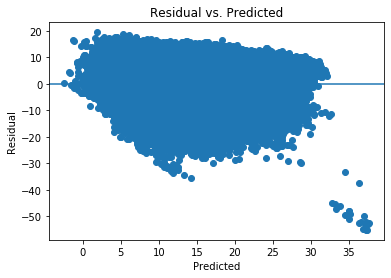

In [22]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [24]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 2464.84 and p value is 0
Levene test statistic value is 2321.24 and p value is 0


### We reject Null Hypothesis and our errors are heteroscedastic

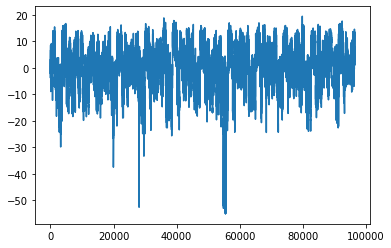

In [25]:
plt.plot(errors)

### Errors are not correlated from the above plot

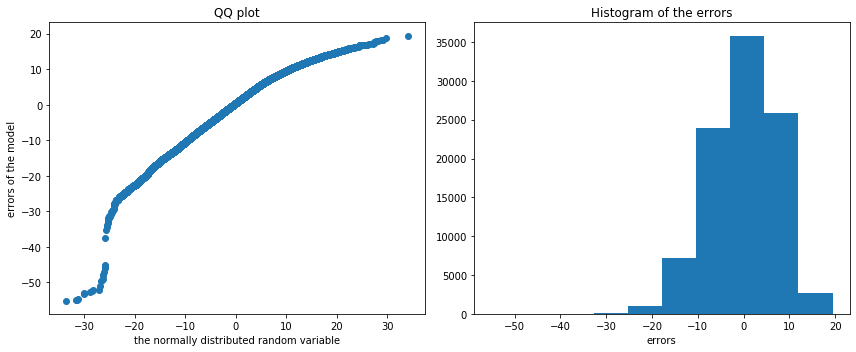

In [26]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

### Errors are not normally distributed, however, the errors are close to normal

### The errors in this model are Heteroscedastic, we can solve this problem by dealing with outliers and selecting relevant features

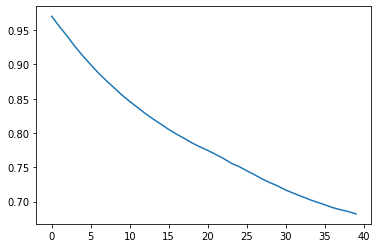

In [27]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

In [28]:
acf_data

array([1.        , 0.97035124, 0.9553087 , 0.94116457, 0.92603952,
       0.91242042, 0.89979506, 0.887476  , 0.87647   , 0.86599514,
       0.85549583, 0.84608609, 0.83739718, 0.82848643, 0.82047967,
       0.81292243, 0.80525289, 0.79838646, 0.79214658, 0.78550952,
       0.77983216, 0.77468981, 0.76896947, 0.76297119, 0.75602989,
       0.75115273, 0.74498537, 0.73918421, 0.73287454, 0.72747751,
       0.7226405 , 0.71684414, 0.71221382, 0.70769778, 0.70315359,
       0.69920983, 0.69536626, 0.69129107, 0.68822196, 0.68548871,
       0.68206578])

### The errors in the model are correlated and our predictions are not reliable and coefficients are biased